# About the project
The work is all about tackling software effort prediction (SEP) and software test prediction (STP) (i.e., software reliability problems) by integrating a metaheuristicm algorith with a ML model to optimize the model's parameters.
Here JAYA algorithm is used in other to improve a Support Vector Regressor SVR model's predictions (predicting the Software effort). Using the Jaya algorithm to optimize the SVR parameters (C, epsilon, gamma).

- The final goal of the project is to compare the results gotten with the results published in a paper by  Sofian Kassaymeh, Salwani Abdullah, Mohamad Al-Laham and others, titled: Salp Swarm Optimizer for Modeling Software Reliability Prediction Problem.
- The same datasets are used.

In [103]:
# Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error

In [104]:
# Load dataset
df = pd.read_csv("dataset/albrecht.csv")
df.head()

,Input,Output,Inquiry,File,FPAdj,RawFPcounts,AdjFP,Effort
0,25.0,150.0,75.0,60.0,1.00,1750.00,1750.0,102.4
1,193.0,98.0,70.0,36.0,1.00,1902.00,1902.0,105.2
2,70.0,27.0,0.0,12.0,0.80,535.00,428.0,11.1
3,40.0,60.0,20.0,12.0,1.15,660.00,759.0,21.1
4,10.0,69.0,1.0,9.0,0.90,478.89,431.0,28.8


# Option 1: Run model and Predictions without Feature Selection

In [105]:
X = df.drop(columns=["Effort"])
y = df["Effort"]

In [106]:
# Scale features and target
scaler_x = StandardScaler()
scaler_y = StandardScaler()
X_scaled = scaler_x.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1)).flatten()

In [107]:
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

## SVR only

In [108]:
# Running the SVR model only without JAYA optimization
model1 = SVR(C=100, epsilon=0.1, gamma=0.005)
model1.fit(X_train, y_train)
y_pred1 = model1.predict(X_test)
mse = mean_squared_error(y_test, y_pred1)
mse

0.05145375033425699

In [109]:
y_predr = scaler_y.inverse_transform(y_pred1.reshape(-1, 1))  # Reverse scaling to get the original values
y_testr = scaler_y.inverse_transform(y_test.reshape(-1, 1))
print(y_predr)
print(y_testr)
print("mse: ", mean_squared_error(y_testr, y_predr))

[[20.85054176]
 [17.03460117]
 [95.57385091]
 [31.26217673]
 [ 9.29866615]]
[[ 12.9]
 [ 18.3]
 [102.4]
 [ 38.1]
 [  2.9]]
mse:  39.82148308134704


## SVR with JAYA optimization

In [110]:
def fitness_function(params, X_train, y_train):
    try:
        C, epsilon, gamma = params
        model = SVR(C=C, epsilon=epsilon, gamma=gamma)
        
        # Use cross-validation on the training set
        # train on 80% of training data, validate on 20%
        X_train_train, X_val, y_train_train, y_val = train_test_split(
            X_train, y_train, test_size=0.2, random_state=42)
        
        model.fit(X_train_train, y_train_train)
        y_pred = model.predict(X_val)
        mse = mean_squared_error(y_val, y_pred)
        return mse
    except:
        return float('inf')

In [111]:
def jaya_optimizer(fitness_fn, bounds, pop_size=10, iterations=100):
    dim = len(bounds)
    population = np.random.uniform([b[0] for b in bounds], [b[1] for b in bounds], size=(pop_size, dim))
    mse_per_iter = []

    for it in range(iterations):
        fitness_values = [fitness_fn(ind, X_train, y_train) for ind in population]
        best_idx, worst_idx = np.argmin(fitness_values), np.argmax(fitness_values)
        best, worst = population[best_idx], population[worst_idx]

        for i in range(pop_size):
            r1, r2 = np.random.rand(dim), np.random.rand(dim)
            new_ind = population[i] + r1 * (best - abs(population[i])) - r2 * (worst - abs(population[i]))
            new_ind = np.clip(new_ind, [b[0] for b in bounds], [b[1] for b in bounds])
            new_fit = fitness_fn(new_ind, X_train, y_train)
            if new_fit < fitness_values[i]:
                population[i] = new_ind

        mse_per_iter.append(min(fitness_values))

    final_fitness = [fitness_fn(ind, X_train, y_train) for ind in population]
    best_index = np.argmin(final_fitness)
    return population[best_index], final_fitness[best_index], mse_per_iter

In [112]:
# SVR hyperparameter bounds: C, epsilon, gamma
bounds = [(100, 1000), (0.05, 0.2), (0.001, 0.005)]

In [113]:
best_params, best_mse, mse_progression = jaya_optimizer(fitness_function, bounds, pop_size=10, iterations=100)

print("Best Parameters (C, epsilon, gamma):", best_params)
print("Best MSE on validation set:", best_mse)

Best Parameters (C, epsilon, gamma): [1.09240356e+02 5.00000000e-02 4.98561717e-03]
Best MSE on validation set: 0.029824382382710277


In [114]:
# Now evaluate the best model on the test set (unseen data)
best_model = SVR(C=best_params[0], epsilon=best_params[1], gamma=best_params[2])
best_model.fit(X_train, y_train)
y_test_pred = best_model.predict(X_test)
test_mse = mean_squared_error(y_test, y_test_pred)
print("Test MSE on unseen data:", test_mse)

Test MSE on unseen data: 0.04634294714679486


In [115]:
y_test_predr = scaler_y.inverse_transform(y_test_pred.reshape(-1, 1))  # Reverse scaling to get the original values
y_testr = scaler_y.inverse_transform(y_test.reshape(-1, 1))
print(y_predr)
print(y_testr)
print("mse: ", mean_squared_error(y_testr, y_test_predr))

[[20.85054176]
 [17.03460117]
 [95.57385091]
 [31.26217673]
 [ 9.29866615]]
[[ 12.9]
 [ 18.3]
 [102.4]
 [ 38.1]
 [  2.9]]
mse:  35.86609088273177


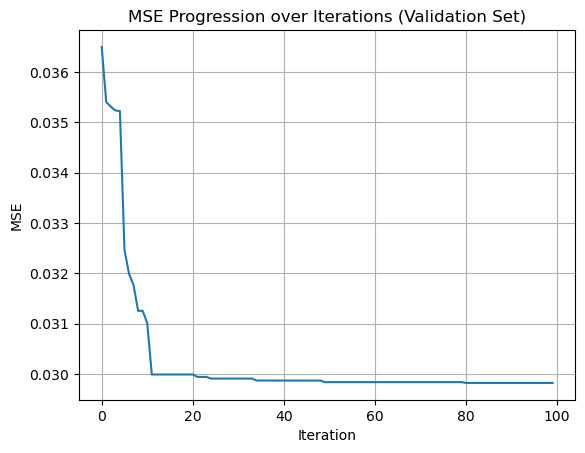

In [116]:
plt.plot(mse_progression)
plt.xlabel("Iteration")
plt.ylabel("MSE")
plt.title("MSE Progression over Iterations (Validation Set)")
plt.grid(True)
plt.show()

# Option 2: Implementing Feature Selections 

- The model's MSE value from option 1: SVR only will be used as a baseline value to see if the feature selections helps in improving the model's performance

In [117]:
df2 = df.copy()

In [118]:
df2.head()

,Input,Output,Inquiry,File,FPAdj,RawFPcounts,AdjFP,Effort
0,25.0,150.0,75.0,60.0,1.00,1750.00,1750.0,102.4
1,193.0,98.0,70.0,36.0,1.00,1902.00,1902.0,105.2
2,70.0,27.0,0.0,12.0,0.80,535.00,428.0,11.1
3,40.0,60.0,20.0,12.0,1.15,660.00,759.0,21.1
4,10.0,69.0,1.0,9.0,0.90,478.89,431.0,28.8


In [119]:
# Feature Selection: Step 1 -> Pearson Correlation
df2.corrwith(df['Effort']).drop("Effort")

Input          0.628075
Output         0.876030
Inquiry        0.840994
File           0.761471
FPAdj          0.234605
RawFPcounts    0.949967
AdjFP          0.935014
dtype: float64

In [120]:
# From the values above, FPAdj has the lowest cor with our target. We'll drop it, including Input... just to have all the cor value be 0.65 and above
X1 = df2.drop(["FPAdj", "Input", "Effort"], axis=1)
y1 = df2["Effort"]

In [121]:
# Scale features and target
X1_scaled = scaler_x.fit_transform(X1)
y1_scaled = scaler_y.fit_transform(y1.values.reshape(-1, 1)).flatten()

In [122]:
# Split dataset
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1_scaled, y1_scaled, test_size=0.2, random_state=42)

In [123]:
# Running the SVR model only without JAYA optimization
model1 = SVR(C=100, epsilon=0.1, gamma=0.005)
model1.fit(X_train1, y_train1)
y_pred_cor = model1.predict(X_test1)
mse = mean_squared_error(y_test1, y_pred_cor)
mse

0.08057129814145039

- With feature selection the new mse 0.11259 compared to the previous 0.05696, shows that the model's prediction got worse.

In [124]:
y_cor_predr = scaler_y.inverse_transform(y_pred_cor.reshape(-1, 1))  # Reverse scaling to get the original values
y_cor_testr = scaler_y.inverse_transform(y_test1.reshape(-1, 1))
print(y_cor_predr)
print(y_cor_testr)
print("mse: ", mean_squared_error(y_cor_testr, y_cor_predr))

[[ 20.70143509]
 [ 17.92403341]
 [115.8804606 ]
 [ 30.29918245]
 [  5.76399858]]
[[ 12.9]
 [ 18.3]
 [102.4]
 [ 38.1]
 [  2.9]]
mse:  62.3563601280545


In [125]:
#X1.var()

In [126]:
# Using Mutual information to see if there are any features that could be dropped also

In [127]:
col = X1.shape[1]

In [128]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression

In [129]:
mse_list = []
for k in range(1, col + 1):  # loop through number of features
    selector = SelectKBest(mutual_info_regression, k=k)
    selector.fit(X_train1, y_train1)

    sel_X_train = selector.transform(X_train1)
    sel_X_test = selector.transform(X_test1)

    model1.fit(sel_X_train, y_train1)
    kbest_preds = model1.predict(sel_X_test)
    mse_kbest = round(mean_squared_error(y_test1, kbest_preds), 4)

    mse_list.append(mse_kbest)

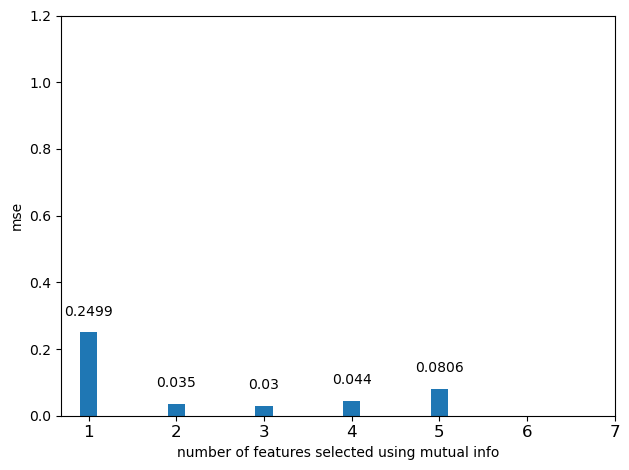

In [130]:
fig, ax = plt.subplots()

x = np.arange(1, col+1)
y = mse_list

ax.bar(x, y, width= 0.2)
ax.set_xlabel ("number of features selected using mutual info")
ax.set_ylabel ("mse")
ax.set_ylim(0, 1.2)
ax.set_xticks(np.arange(1,8))
ax.set_xticklabels(np.arange(1, 8), fontsize=12)

for i, v in enumerate(y):
    plt.text(x=i+1, y=v+0.05, s=str(v), ha='center')
plt.tight_layout()

In [131]:
# top features selected
selector = SelectKBest(mutual_info_regression, k=3)
selector.fit(X_train1, y_train1)

selected_feature_mask = selector.get_support()
#X_scaled = pd.DataFrame(scaler_x.fit_transform(X), columns=X.columns)
selected_features = X1.columns[selected_feature_mask]
selected_features

Index(['Output', 'RawFPcounts', 'AdjFP'], dtype='object')

- From the plot above, it shows that at k=3, the feature selection has improved the model's prediction from 0.08057 to 0.03, we'll try using the 3 features

In [137]:
# Selecting the k=3 features
X1 = df2[['Output', 'RawFPcounts', 'AdjFP']]
# Scale features and target
X1_scaled = scaler_x.fit_transform(X1)

In [138]:
# Split dataset
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1_scaled, y1_scaled, test_size=0.2, random_state=42)

In [139]:
# Running the SVR model only without JAYA optimization
model1 = SVR(C=100, epsilon=0.1, gamma=0.005)
model1.fit(X_train1, y_train1)
y_pred_cor = model1.predict(X_test1)
mse = mean_squared_error(y_test1, y_pred_cor)
mse

0.030011965128749745

- Using the features from k=3 has improved the model.

In [132]:
# Running the Jaya-svr optimization with new selected features

In [140]:
def jaya_optimizer(fitness_fn, bounds, pop_size=10, iterations=100):
    dim = len(bounds)
    population = np.random.uniform([b[0] for b in bounds], [b[1] for b in bounds], size=(pop_size, dim))
    mse_per_iter = []

    for it in range(iterations):
        fitness_values = [fitness_fn(ind, X_train1, y_train1) for ind in population]
        best_idx, worst_idx = np.argmin(fitness_values), np.argmax(fitness_values)
        best, worst = population[best_idx], population[worst_idx]

        for i in range(pop_size):
            r1, r2 = np.random.rand(dim), np.random.rand(dim)
            new_ind = population[i] + r1 * (best - abs(population[i])) - r2 * (worst - abs(population[i]))
            new_ind = np.clip(new_ind, [b[0] for b in bounds], [b[1] for b in bounds])
            new_fit = fitness_fn(new_ind, X_train1, y_train1)
            if new_fit < fitness_values[i]:
                population[i] = new_ind

        mse_per_iter.append(min(fitness_values))

    final_fitness = [fitness_fn(ind, X_train1, y_train1) for ind in population]
    best_index = np.argmin(final_fitness)
    return population[best_index], final_fitness[best_index], mse_per_iter

In [141]:
best_params, best_mse, mse_progression = jaya_optimizer(fitness_function, bounds, pop_size=10, iterations=100)

print("Best Parameters (C, epsilon, gamma):", best_params)
print("Best MSE on validation set:", best_mse)

Best Parameters (C, epsilon, gamma): [1.00000000e+03 1.97890821e-01 4.99567657e-03]
Best MSE on validation set: 0.012084979392805145


In [142]:
# Now evaluate the best model on the test set (unseen data)
best_model = SVR(C=best_params[0], epsilon=best_params[1], gamma=best_params[2])
best_model.fit(X_train1, y_train1)
y_test_pred = best_model.predict(X_test1)
test_mse = mean_squared_error(y_test1, y_test_pred)
print("Test MSE on unseen data:", test_mse)

Test MSE on unseen data: 0.05226668134969344


In [143]:
y_test_predr = scaler_y.inverse_transform(y_test_pred.reshape(-1, 1))  # Reverse scaling to get the original values
y_testr = scaler_y.inverse_transform(y_test1.reshape(-1, 1))
print(y_predr)
print(y_testr)
print("mse: ", mean_squared_error(y_testr, y_test_predr))

[[20.85054176]
 [17.03460117]
 [95.57385091]
 [31.26217673]
 [ 9.29866615]]
[[ 12.9]
 [ 18.3]
 [102.4]
 [ 38.1]
 [  2.9]]
mse:  40.4506329191568


# Final Results:
    Based on all the test runs, this is the conclusion:
###  Results without feature selection (MSE)
- SVR only -> 0.05145375033425699     | reversed scale: 39.82148308134704
- JAYA-SVR -> 0.04634294714679486   | reversed scale: 35.86609088273177
###  Results with feature selection
- SVR only -> 0.030011965128749745    | reversed scale: 
- JAYA-SVR -> 0.05226668134969344   | reversed scale: 40.4506329191568

### Using feature selection improved the model's prediction (the best outcome out of all options) but optimizing the model using JAYA-SVR (with feature selection) algorithm does not improve the model... on this dataset.

## Results from the published paper, for this dataset
- BPNN only -> 0.5474
- SSA-BPNN -> 0.0161
> Back Propagation Neural Network (BPNN) & Salp Swarm Algorithm (SSA)

#### Confusion???
Why is the result better when the dataset is scaled down but looks worse when the scaling is reversed?